# Проект Danss
В данном проекте определяются поправки к зависимости осциляций нетрино от пройденого пути вызваные не точечностью источника частиц и детектора.



## Задача
Определить распределение электроного и мюоного нейтрино в детекторе расположеного возле реактора.


## Геометрия задачи
Рассмотрим следующию модель:реактор - цилиндр с высотой H и радиусом R

*   реактор - цилиндр с высотой $H$ и радиусом $R$
*   детектор - куб с длиной ребра $a$
*   Взаимное расположение: куб и цилиндр стоят на одной плоскости. $L$ - растояие между центрами фигур, $\theta$ - угол поворота куба в этой плоскости
(т.е. угл между прямой соединяющей центры фигур и нормалью грани)

Если мы будим использовать декардовы координаты от центра основания для точки из детектора ($x, y, z$) и цилиндрические координаты для точки из реактора ($h, r, \varphi$), то растояние между точкой из реактора и точкой из детектора будет:

$ l=\sqrt{(L-r\cos \varphi -y\cos θ +x\sin θ)^2 + (r\sin \varphi +y\sin θ +x\cos θ)^2 +(z-h)^2}$

Распределение растояний будет тогда:

$$ F(l) = \frac{\int_{l(...)=l}{dxdydzdhdrdφ}}{\int{dxdydzdhdrdφ}}=\frac{1}{\pi R^2Ha^3}\int_{l(...)=l}{dxdydzdhdrdφ}$$

Как видно, в явном виде посчитать этот интеграл не представляется возможным.

Для нахождения F(l) сделаем численый расчёт.

## Численый метод определения распределения
Код находится в "main.cpp"

### Метод прямого перебора

В методе прямого перебора мы создаём регулярную сетку точек в объёмах куба и цилиндра с неким шагом.

Главный недостаток даного метода связан с длительностью исполнения вложеных циклов при достаточно малого шага сетки (число пар растёт как $(\frac{\text{размеры тел}}{ϵ})^6 \sim 10^{3*6}$).

### Метод Монте-Карло
Для ускорения расчёта мы можем генерировать две случайые точки с равномерным распределением в объёмах детектора и реактора, а потом определять растоянием между ними. Таким образом мы пролучаем репрезентативную выборотку пар точек и соотвествующих длин.
Даный метод работает быстрее потому что достаточно сгенерировать выборотку длиной примерно $10^6$

Один из главных моментов в методе является правильный выбор распределения вероятностей в ГПСЧ. Наша цель сделать равномерно по объёму, т.е. т.е. для любого интегрирования плотности в. по равновеликим фигурам даёт одно и тоже значение вероятности.
Есть два варианта (по x,y,z,h вопросов нет):
*   равномерно по $φ$ и $r$, тогда в центре "плотнее"
*   равномерно по $φ$ и $\frac{r^2}{2}$ (так как $ds=rdr d\varphi$)

При втором варианте достигается требуемый вариант.


### Отрисовка распределения
Воспользуемся пакетами matplotlib

In [32]:
#Получение данных гистограммы
data=[]
with open('Data', 'r') as file:
    arr=file.readlines()
    for line in arr[9:]:
        data.append(int(line))

In [45]:
#Обработка (добавление длин)
l=[]
for i in range(len(data)):
    l.append(10+ i*0.1)

1300

In [37]:
#Рисование (Импорт)
from matplotlib import pyplot
import matplotlib.pyplot as plt

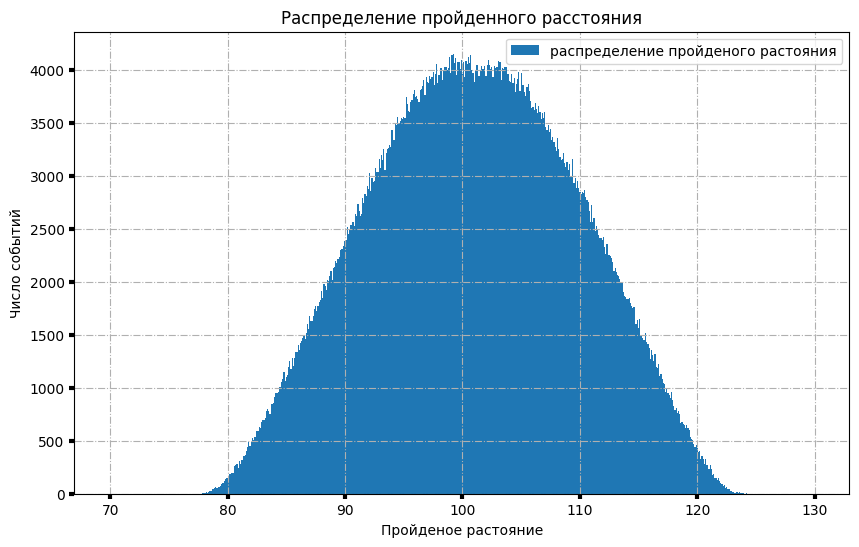

In [88]:
#Рисование гистограммы и другое
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Распределение пройденного расстояния')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

ax.bar(l[600:1200], data[600:1200], linewidth = 1., width = 0.1, label = "распределение пройденого растояния")

ax.legend()
pyplot.show()

## Фитирование распределения $F(l)$

Воспользуемся пакетами scipy.optimize для фитирования полученной гистограммы.

### Поиск пробной функции

In [40]:
#Фитирование (библиотеки)
from scipy.optimize import curve_fit
from math import exp
import numpy as np

In [55]:
#Пробная функция - квадратичная
def mapping_p(x, a, b, c):
    return c-a*np.power(np.abs(x-b), 2)
args_p, covar_p = curve_fit(mapping_p, l[800:1000], data[800:1000], [1.,100.0, 4000.0])
perr = np.sqrt(np.diag(covar_p))
args_p, perr

(array([  14.88862369,  100.86199628, 4079.49847161]),
 array([0.14752311, 0.0271313 , 6.54320237]))

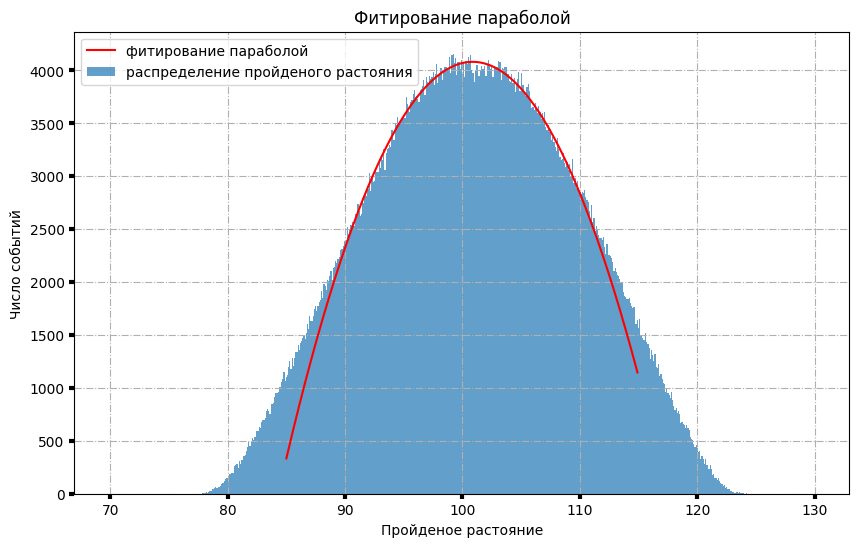

In [91]:
y = []
for i in range(len(l)):
    y.append(mapping_p(l[i], args_p[0], args_p[1], args_p[2]))
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование параболой')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

ax.bar(l[600:1200], data[600:1200], linewidth = 1., width = 0.1, alpha = 0.7, label = "распределение пройденого растояния")
ax.plot(l[750:1050], y[750:1050], color='r', label = "фитирование параболой")
ax.legend()
pyplot.show()

In [64]:
#Фитирование гаусовым пиком
def mapping2(x, a, b, c, d):
    return a*np.exp(-(x-b)**2 /c)+d
args, covar = curve_fit(mapping2, l[600:1200], data[600:1200], [4000.0,100.0, 1.0,0.0])
perr = np.sqrt(np.diag(covar))
args_p, perr

(array([  14.88862369,  100.86199628, 4079.49847161]),
 array([13.6789132 ,  0.02677266,  1.95659121, 12.55451385]))

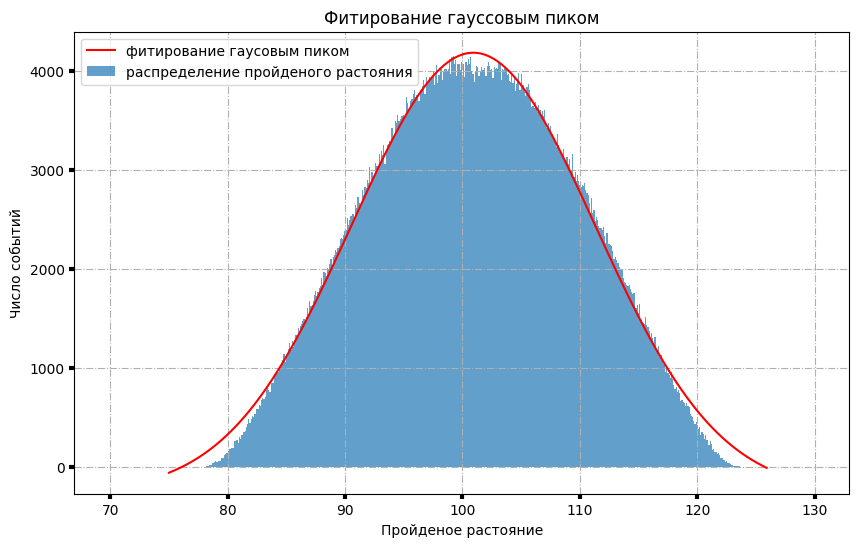

In [92]:
y = []
for i in range(len(l)):
    y.append(mapping2(l[i], args[0], args[1], args[2], args[3]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование гауссовым пиком')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)


ax.bar(l[600:1200], data[600:1200], linewidth = 1., width = 0.1, alpha = 0.7, label = "распределение пройденого растояния")
ax.plot(l[650:1160], y[650:1160], color='r', label = "фитирование гаусовым пиком")
ax.legend()
pyplot.show()

### Определение зависимости от параметров
Проделаем серию вычислений, для разных значений параметров задачи: $a, R, H, L, θ$

Для простоты фитирование вынесено в отдельный файл.

Итого мы имеем вид распределения F(l):
$$F(l)=a e^{(l-b)^2 /c} - d$$